In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage as ndi
from skimage import color, io, morphology
from skimage.filters import threshold_otsu

In [2]:
def imread_x(f,path,box=(0,792,0,85)):
    return color.rgb2gray(io.imread(
            r'D:\Mestrado\Imagens\Antigas'
            + path + '(%d).jpg'%f)[box[0]:box[1],
                                   box[2]:box[3]])

def im_start(pic,path,box):
    im_matrix = io.ImageCollection(
            pic,path=path,box=box,
            load_func=imread_x)
    return(im_matrix.concatenate())

def bg_im(im):
    bg = np.zeros(im.shape,dtype=int)
    bg[:,0:np.floor_divide(im.shape[1],2)] = 255
    return(bg)

def bg_removal(im_mat):
    bg = bg_im(im_mat[0])
    im_int = im_mat * 255
    im_int = im_int.astype(int)
    no_bg = im_int - bg
    no_bg[no_bg < 0] = 0
    return(no_bg)

def im_proc(im):
    th = threshold_otsu(im)
    im_bin = im > th
    return(ndi.binary_fill_holes(
                morphology.closing(
                im_bin,np.ones((3,3)))))

def interface_height(im,scale):
    D = {n: np.array([i for i, j in enumerate(k) if j]) for n, k in enumerate(im)}
    height = []#np.array([np.amin(i) for i in list(D.values()) if list(D.values())])
    for v in D.values():
        if len(v) == 0:
            height.append(height[-1])
        else:
            height.append(np.min(v))
    return(D,height)

In [3]:
pics = np.linspace(1,5e2,5e2)
location = r'\Alta\30\253\Imagem '
ROI = (0,792,6,68)
%timeit -r 1 im_start(pics,path=location,box=ROI)

The slowest run took 5.43 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 1: 1.36 s per loop


In [4]:
iarray = im_start(pics,path=location,box=ROI)
type(iarray),iarray.shape

(numpy.ndarray, (500, 792, 62))

In [5]:
%timeit -r 1 bg_removal(iarray)

10 loops, best of 1: 178 ms per loop


In [6]:
iarray_b = bg_removal(iarray)
iarray_b.shape

(500, 792, 62)

In [7]:
%timeit -r 1 im_proc(iarray_b[0])

100 loops, best of 1: 2.73 ms per loop


(-0.5, 61.5, 791.5, -0.5)

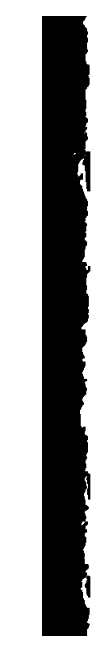

In [8]:
plt.figure(figsize=(4,8))
plt.imshow(im_proc(iarray_b[0]),cmap=plt.cm.gray)
plt.axis('off')

In [9]:
%timeit -r 1 np.array([im_proc(i) for i in iarray_b])

1 loop, best of 1: 1.42 s per loop


In [10]:
iarray_p = np.array([im_proc(i) for i in iarray_b])
iarray_p.shape, type(iarray_p)

((500, 792, 62), numpy.ndarray)

In [11]:
%timeit -r 1 np.array([interface_height(i,62) for i in iarray_p])

1 loop, best of 1: 2.92 s per loop


In [12]:
iarray_h = [interface_height(ii,62) for ii in iarray_p]
#iarray_h

In [13]:
D = {n: np.array([i for i, j in enumerate(k) if j]) for n, k in enumerate(iarray_p[0])}
#for i,k in enumerate(D.values()):
    #print(i,k)

[0, 800, 0, 5]

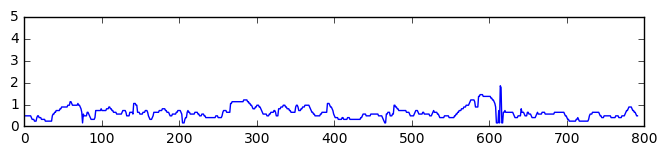

In [23]:
a1,a2 = interface_height(iarray_p[0],62)
a1,a2
plt.figure(figsize=(8,2/np.sqrt(2)))
plt.plot(5-5*np.flipud(np.array(a2))/62)
plt.axis([0,800,0,5])

In [15]:
h1 = np.zeros((iarray_p.shape[0],iarray_p.shape[1]))
for j,ii in enumerate(iarray_p):
    iarray_D, iarray_h = interface_height(ii,62)
    h1[j] = iarray_h
#h1 = np.array(h1,dtype=int)

In [16]:
iarray_p.shape,np.zeros((iarray_p.shape[0],iarray_p.shape[1])).shape

((500, 792, 62), (500, 792))

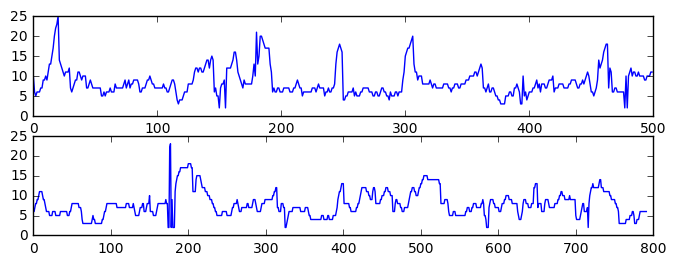

In [24]:
fig = plt.figure(figsize=(8,4/np.sqrt(2)))
ax1 = fig.add_subplot(211)
ax1.plot(62-h1[:,150])
ax2 = fig.add_subplot(212)
ax2.plot(62-h1[0,:])

(-60, 80)

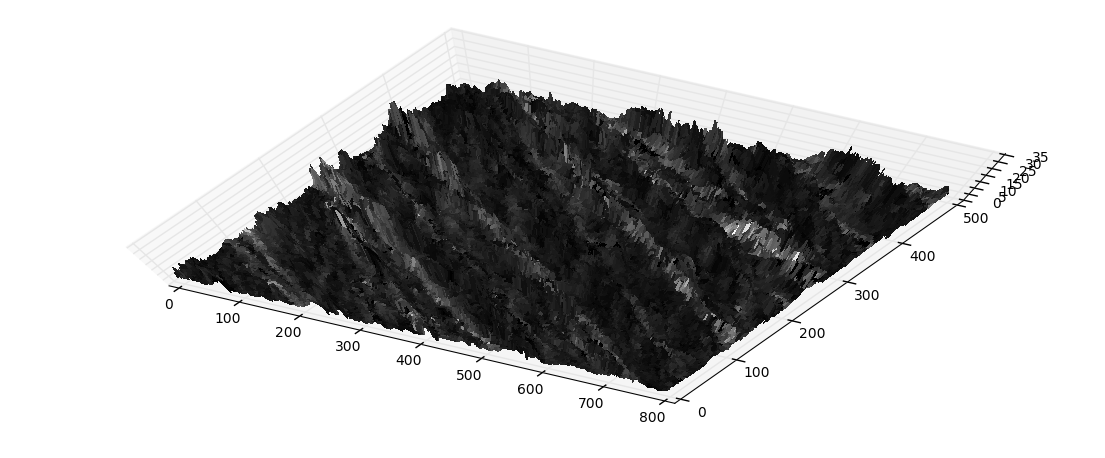

In [18]:
x = np.arange(0,792,1,dtype=int)
y = np.arange(0,500,1,dtype=int)
X,Y = np.meshgrid(x,y)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

light = LightSource(240,215)
illuminated_surface = light.shade(5*(1-h1/62), cmap=plt.cm.gray)
fig = plt.figure(figsize=(14,8/np.sqrt(2)))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,62-np.flipud(np.fliplr(h1)),rstride=4,cstride=4,
                facecolors=illuminated_surface,linewidth=0, antialiased=False)
ax.view_init(azim=-60,elev=80)
ax.axes.azim,ax.axes.elev
#plt.grid('off')
#plt.tight_layout()

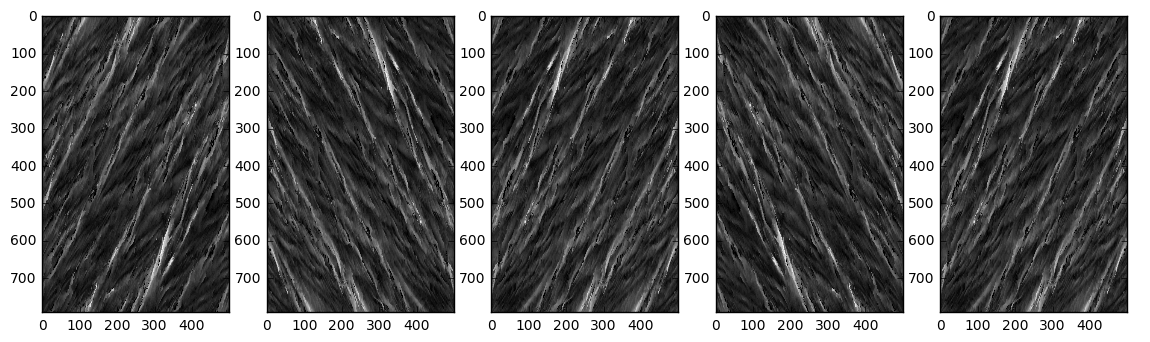

In [19]:
fig, axes = plt.subplots(ncols=5, figsize=(14,6))
ax = axes.ravel()
ax[0].imshow(62-h1.T,cmap=plt.cm.gray)
ax[1].imshow(62-np.fliplr(h1).T,cmap=plt.cm.gray)
ax[2].imshow(62-np.flipud(np.fliplr(h1)).T,cmap=plt.cm.gray)
ax[3].imshow(62-np.flipud(h1).T,cmap=plt.cm.gray)
ax[4].imshow(62-np.fliplr(np.flipud(h1)).T,cmap=plt.cm.gray)

In [20]:
print(h1),print(np.fliplr(h1)),print(np.flipud(np.fliplr(h1))),print(np.flipud(h1))

[[ 56.  56.  55. ...,  56.  56.  56.]
 [ 56.  56.  55. ...,  56.  56.  56.]
 [ 55.  55.  54. ...,  57.  57.  56.]
 ..., 
 [ 54.  54.  54. ...,  52.  52.  52.]
 [ 55.  55.  55. ...,  53.  53.  53.]
 [ 55.  55.  55. ...,  53.  56.  56.]]
[[ 56.  56.  56. ...,  55.  56.  56.]
 [ 56.  56.  56. ...,  55.  56.  56.]
 [ 56.  57.  57. ...,  54.  55.  55.]
 ..., 
 [ 52.  52.  52. ...,  54.  54.  54.]
 [ 53.  53.  53. ...,  55.  55.  55.]
 [ 56.  56.  53. ...,  55.  55.  55.]]
[[ 56.  56.  53. ...,  55.  55.  55.]
 [ 53.  53.  53. ...,  55.  55.  55.]
 [ 52.  52.  52. ...,  54.  54.  54.]
 ..., 
 [ 56.  57.  57. ...,  54.  55.  55.]
 [ 56.  56.  56. ...,  55.  56.  56.]
 [ 56.  56.  56. ...,  55.  56.  56.]]
[[ 55.  55.  55. ...,  53.  56.  56.]
 [ 55.  55.  55. ...,  53.  53.  53.]
 [ 54.  54.  54. ...,  52.  52.  52.]
 ..., 
 [ 55.  55.  54. ...,  57.  57.  56.]
 [ 56.  56.  55. ...,  56.  56.  56.]
 [ 56.  56.  55. ...,  56.  56.  56.]]


(None, None, None, None)